In [1]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
# import os
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset
# import torch

# class RAFDBDataset(Dataset):
#     def __init__(self, csv_file, img_dir, transform=None):
#         self.labels = pd.read_csv(csv_file)
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
#         image = Image.open(img_name)
#         label = self.labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)

#         return image, label

In [3]:
from get_dataset import GiMeFiveDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
rafdb_dataset_train = GiMeFiveDataset(csv_file='data/train_labels.csv',
                            img_dir='data/train/',
                            transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = GiMeFiveDataset(csv_file='data/valid_labels.csv',
                            img_dir='data/valid',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

rafdb_dataset_test = GiMeFiveDataset(csv_file='data/test_labels.csv',
                            img_dir='data/test/',
                            transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [4]:
class SEBlock(nn.Module): # Squeeze-and-Excitation (SE) blocks apply channel-wise attention.
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_channels, input_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_channels // reduction, input_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out

In [6]:

# class EmotionClassifier(nn.Module):
#     def __init__(self):
#         super(EmotionClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.se1 = SEBlock(64)

#         self.res_block1 = ResidualBlock(64, 128, stride=2)
#         self.res_block2 = ResidualBlock(128, 256, stride=2)
#         self.res_block3 = ResidualBlock(256, 512, stride=2)
#         self.res_block4 = ResidualBlock(512, 1024, stride=2)
#         self.res_block5 = ResidualBlock(1024, 2048, stride=2)

#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(2048, 4096)
#         self.fc2 = nn.Linear(4096, 2048) 
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(2048, 6)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.se1(x)
        
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
#         x = self.res_block5(x)
        
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# model = EmotionClassifier().to(device)

In [7]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 1024) 
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 6)

    def forward(self, x): # (batch_size, channels=3, 64, 64)
        x = F.relu(self.bn1(self.conv1(x))) # (batch_size, 64, 64, 64)
        x = F.max_pool2d(x, 2) # (batch_size, 64, 32, 32)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x))) # (batch_size, 128, 32, 32)
        x = F.max_pool2d(x, 2) # (batch_size, 128, 16, 16)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x))) # (batch_size, 256, 16, 16)
        x = F.max_pool2d(x, 2) # (batch_size, 256, 8, 8)
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.conv4(x))) # (batch_size, 512, 8, 8)
        x = F.max_pool2d(x, 2) # (batch_size, 512, 4, 4)
        x = self.dropout1(x)
        x = F.relu(self.bn5(self.conv5(x))) # (batch_size, 1024, 4, 4)
        x = F.max_pool2d(x, 2) # (batch_size, 1024, 2, 2)
        # x = self.dropout1(x)
        
        x = self.pool(x) # (batch_size, 1024, 1, 1)
        x = x.view(x.size(0), -1) # (batch_size, 1024) # Flatten
        x = F.relu(self.fc1(x)) # (batch_size, 2048)
        x = self.dropout2(x) # (batch_size, 2048)
        x = F.relu(self.fc2(x)) # (batch_size, 1024)
        x = self.fc3(x) # (batch_size, 6)
        return x

model = EmotionClassifier().to(device)

In [8]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

In [9]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 10478086


In [10]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion * planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=6):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out

# def EmotionClassifierResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

# model = EmotionClassifierResNet18().to(device)


In [11]:
# param_grid = {
#     'lr': [0.1, 0.01, 0.001, 0.0001], 
#     'batch_size': [8, 16, 32, 64],  
# }
# grid = ParameterGrid(param_grid)
# results = []

In [12]:
# for params in grid: # Hyperparameter tuning 
#     data_train_loader = DataLoader(rafdb_dataset_train, batch_size=params['batch_size'], shuffle=True, num_workers=4)
#     data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=params['batch_size'], shuffle=False, num_workers=0)
    
#     model = EmotionClassifier().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=params['lr'])
#     criterion = nn.CrossEntropyLoss()
    
#     best_val_acc = 0
#     num_epochs = 15
    
#     for epoch in range(num_epochs):
#         model.train()
#         for i, data in enumerate(tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 0):
#             inputs, labels = data[0].to(device), data[1].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for data in data_vali_loader:
#             inputs, labels = data[0].to(device), data[1].to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()
    
#     val_acc = val_correct / val_total
#     best_val_acc = max(best_val_acc, val_acc)
    
#     results.append({
#         'lr': params['lr'],
#         'batch_size': params['batch_size'],
#         'best_val_acc': best_val_acc,
#     })

# for result in results:
#     print(f"LR: {result['lr']}, Batch Size: {result['batch_size']}, Best Val Acc: {result['best_val_acc']}")

# best_params = max(results, key=lambda x: x['best_val_acc'])
# print(f"Best params: {best_params}")

In [13]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


patience = 15
best_val_acc = 0  
patience_counter = 0

num_epochs = 80

In [14]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/80: 100%|██████████| 3442/3442 [02:30<00:00, 22.83it/s]


Epoch 1, Train Loss: 1.5361331642574518, Train Accuracy: 0.3828512284142289, Test Loss: 1.5177604989676008, Test Accuracy: 0.4529524723955833, Validation Loss: 2.5048919320106506, Validation Accuracy: 0.21702838063439064


Epoch 2/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.43it/s]


Epoch 2, Train Loss: 1.2516593146400352, Train Accuracy: 0.5029507363222022, Test Loss: 1.1547817667899742, Test Accuracy: 0.5602496399423907, Validation Loss: 1.775279440377888, Validation Accuracy: 0.3772954924874791


Epoch 3/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.44it/s]


Epoch 3, Train Loss: 1.13893609658914, Train Accuracy: 0.5488187975522507, Test Loss: 1.0219687683053758, Test Accuracy: 0.6059769563130101, Validation Loss: 1.409988089611656, Validation Accuracy: 0.48914858096828046


Epoch 4/80: 100%|██████████| 3442/3442 [02:27<00:00, 23.31it/s]


Epoch 4, Train Loss: 1.0703143208508987, Train Accuracy: 0.5785622196800494, Test Loss: 0.9631279086740598, Test Accuracy: 0.6271003360537686, Validation Loss: 1.4833757296988839, Validation Accuracy: 0.48080133555926546
No improvement in validation accuracy for 1 epochs.


Epoch 5/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.43it/s]


Epoch 5, Train Loss: 1.0205659462676915, Train Accuracy: 0.5972471899911024, Test Loss: 0.918651647379554, Test Accuracy: 0.6518242918867019, Validation Loss: 1.2420421274084794, Validation Accuracy: 0.5525876460767947


Epoch 6/80: 100%|██████████| 3442/3442 [02:27<00:00, 23.41it/s]


Epoch 6, Train Loss: 0.9813546312194726, Train Accuracy: 0.6161500608305642, Test Loss: 0.924646738691402, Test Accuracy: 0.6493038886221796, Validation Loss: 1.3124499775861438, Validation Accuracy: 0.5459098497495827
No improvement in validation accuracy for 1 epochs.


Epoch 7/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.46it/s]


Epoch 7, Train Loss: 0.9548080499559416, Train Accuracy: 0.6260463764957963, Test Loss: 0.8863938357037512, Test Accuracy: 0.663106096975516, Validation Loss: 1.2657898413507562, Validation Accuracy: 0.5592654424040067


Epoch 8/80: 100%|██████████| 3442/3442 [02:27<00:00, 23.39it/s]


Epoch 8, Train Loss: 0.9312953537612513, Train Accuracy: 0.6335821031032667, Test Loss: 0.867204228396422, Test Accuracy: 0.6753480556889102, Validation Loss: 1.2850686766599353, Validation Accuracy: 0.5792988313856428


Epoch 9/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.48it/s]


Epoch 9, Train Loss: 0.9070461599079417, Train Accuracy: 0.6454213651468105, Test Loss: 0.8406515143625796, Test Accuracy: 0.685789726356217, Validation Loss: 1.1850031331965798, Validation Accuracy: 0.5893155258764607


Epoch 10/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.48it/s]


Epoch 10, Train Loss: 0.8897132085704443, Train Accuracy: 0.6528844582448112, Test Loss: 0.8495440779293167, Test Accuracy: 0.6819491118578973, Validation Loss: 1.1684284570970034, Validation Accuracy: 0.5943238731218697


Epoch 11/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.45it/s]


Epoch 11, Train Loss: 0.8701277811130004, Train Accuracy: 0.6612917869659167, Test Loss: 0.7994916356470786, Test Accuracy: 0.6952712433989439, Validation Loss: 1.0777938271823682, Validation Accuracy: 0.6243739565943238


Epoch 12/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.55it/s]


Epoch 12, Train Loss: 0.8527153152961636, Train Accuracy: 0.6682101287428955, Test Loss: 0.8510728885988114, Test Accuracy: 0.6839894383101296, Validation Loss: 1.1918339431285858, Validation Accuracy: 0.6193656093489148
No improvement in validation accuracy for 1 epochs.


Epoch 13/80: 100%|██████████| 3442/3442 [02:27<00:00, 23.40it/s]


Epoch 13, Train Loss: 0.838167462054205, Train Accuracy: 0.6739481759909934, Test Loss: 0.8088860591451661, Test Accuracy: 0.6950312049927988, Validation Loss: 1.085681046310224, Validation Accuracy: 0.6393989983305509


Epoch 14/80: 100%|██████████| 3442/3442 [02:27<00:00, 23.40it/s]


Epoch 14, Train Loss: 0.8257990823035875, Train Accuracy: 0.6793412140691107, Test Loss: 0.7926831286143147, Test Accuracy: 0.6987518002880461, Validation Loss: 0.985404972183077, Validation Accuracy: 0.6527545909849749


Epoch 15/80: 100%|██████████| 3442/3442 [02:28<00:00, 23.19it/s]


Epoch 15, Train Loss: 0.8097171833060081, Train Accuracy: 0.6848795191661673, Test Loss: 0.7732598021619322, Test Accuracy: 0.7095535285645703, Validation Loss: 0.9470872188869276, Validation Accuracy: 0.67779632721202


Epoch 16/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.52it/s]


Epoch 16, Train Loss: 0.7954588108617576, Train Accuracy: 0.6895280637722213, Test Loss: 0.8159885503845057, Test Accuracy: 0.6880700912145943, Validation Loss: 1.0352219327499992, Validation Accuracy: 0.66110183639399
No improvement in validation accuracy for 1 epochs.


Epoch 17/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.53it/s]


Epoch 17, Train Loss: 0.7845962807181129, Train Accuracy: 0.6949937353598082, Test Loss: 0.8535047235159962, Test Accuracy: 0.6883101296207393, Validation Loss: 1.1543132741200297, Validation Accuracy: 0.6393989983305509
No improvement in validation accuracy for 2 epochs.


Epoch 18/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.45it/s]


Epoch 18, Train Loss: 0.7743738577297993, Train Accuracy: 0.6996059632111274, Test Loss: 0.7556558610293156, Test Accuracy: 0.7160345655304848, Validation Loss: 0.9417806110884014, Validation Accuracy: 0.6878130217028381


Epoch 19/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.43it/s]


Epoch 19, Train Loss: 0.762625303500392, Train Accuracy: 0.7054892774781646, Test Loss: 0.7647390902675187, Test Accuracy: 0.7119539126260201, Validation Loss: 0.9817241116573936, Validation Accuracy: 0.676126878130217
No improvement in validation accuracy for 1 epochs.


Epoch 20/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.51it/s]


Epoch 20, Train Loss: 0.750351348371266, Train Accuracy: 0.7082675092153765, Test Loss: 0.7504452592487699, Test Accuracy: 0.7149543927028325, Validation Loss: 0.8387673183491355, Validation Accuracy: 0.7045075125208681


Epoch 21/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.43it/s]


Epoch 21, Train Loss: 0.7434639751279097, Train Accuracy: 0.7111546912167929, Test Loss: 0.7478901029183689, Test Accuracy: 0.7210753720595295, Validation Loss: 0.9879200403627596, Validation Accuracy: 0.659432387312187
No improvement in validation accuracy for 1 epochs.


Epoch 22/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.55it/s]


Epoch 22, Train Loss: 0.7323826815822594, Train Accuracy: 0.716220878502297, Test Loss: 0.770713985334517, Test Accuracy: 0.7106337013922227, Validation Loss: 1.006757341717419, Validation Accuracy: 0.669449081803005
No improvement in validation accuracy for 2 epochs.


Epoch 23/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.50it/s]


Epoch 23, Train Loss: 0.7196746068437871, Train Accuracy: 0.7212689074104338, Test Loss: 0.7451662959990354, Test Accuracy: 0.7247959673547768, Validation Loss: 0.989564229783259, Validation Accuracy: 0.6961602671118531
No improvement in validation accuracy for 3 epochs.


Epoch 24/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.53it/s]


Epoch 24, Train Loss: 0.7101060484147986, Train Accuracy: 0.724101614279748, Test Loss: 0.7315547923877435, Test Accuracy: 0.7293566970715314, Validation Loss: 0.8950556006870771, Validation Accuracy: 0.7011686143572621
No improvement in validation accuracy for 4 epochs.


Epoch 25/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.53it/s]


Epoch 25, Train Loss: 0.7001398660801026, Train Accuracy: 0.7319278749250967, Test Loss: 0.7569339965396845, Test Accuracy: 0.7225156024963995, Validation Loss: 0.9436609172507336, Validation Accuracy: 0.6961602671118531
No improvement in validation accuracy for 5 epochs.


Epoch 26/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.45it/s]


Epoch 26, Train Loss: 0.6865388126150942, Train Accuracy: 0.7338889796807757, Test Loss: 0.7723261300709471, Test Accuracy: 0.7187950072011522, Validation Loss: 1.0165177967987562, Validation Accuracy: 0.6978297161936561
No improvement in validation accuracy for 6 epochs.


Epoch 27/80: 100%|██████████| 3442/3442 [02:27<00:00, 23.39it/s]


Epoch 27, Train Loss: 0.6794806036044005, Train Accuracy: 0.7355595503985763, Test Loss: 0.817795006902294, Test Accuracy: 0.7119539126260201, Validation Loss: 1.095565374744566, Validation Accuracy: 0.6894824707846411
No improvement in validation accuracy for 7 epochs.


Epoch 28/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.52it/s]


Epoch 28, Train Loss: 0.671712289142754, Train Accuracy: 0.7391185923625865, Test Loss: 0.7194270744272677, Test Accuracy: 0.7341574651944311, Validation Loss: 0.8413837387373573, Validation Accuracy: 0.7412353923205343


Epoch 29/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.52it/s]


Epoch 29, Train Loss: 0.659868958155597, Train Accuracy: 0.742241833269779, Test Loss: 0.7557639941455163, Test Accuracy: 0.7300768122899663, Validation Loss: 0.886623897834828, Validation Accuracy: 0.7061769616026711
No improvement in validation accuracy for 1 epochs.


Epoch 30/80: 100%|██████████| 3442/3442 [02:27<00:00, 23.40it/s]


Epoch 30, Train Loss: 0.6482988653021591, Train Accuracy: 0.7491964918014926, Test Loss: 0.7566895442500875, Test Accuracy: 0.7299567930868939, Validation Loss: 1.0202352596740973, Validation Accuracy: 0.6944908180300501
No improvement in validation accuracy for 2 epochs.


Epoch 31/80: 100%|██████████| 3442/3442 [02:27<00:00, 23.40it/s]


Epoch 31, Train Loss: 0.6456042462824597, Train Accuracy: 0.7507217955003541, Test Loss: 0.7390339884821204, Test Accuracy: 0.7311569851176188, Validation Loss: 0.8986366108844155, Validation Accuracy: 0.7128547579298832
No improvement in validation accuracy for 3 epochs.


Epoch 32/80: 100%|██████████| 3442/3442 [02:27<00:00, 23.31it/s]


Epoch 32, Train Loss: 0.6315903764332816, Train Accuracy: 0.756732218408963, Test Loss: 0.77910361552165, Test Accuracy: 0.7178348535765723, Validation Loss: 1.0352450781746914, Validation Accuracy: 0.6928213689482471
No improvement in validation accuracy for 4 epochs.


Epoch 33/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.52it/s]


Epoch 33, Train Loss: 0.6262501534215245, Train Accuracy: 0.758330155617294, Test Loss: 0.7209502742009062, Test Accuracy: 0.7412385981757081, Validation Loss: 0.8356563543018541, Validation Accuracy: 0.7111853088480802
No improvement in validation accuracy for 5 epochs.


Epoch 34/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.51it/s]


Epoch 34, Train Loss: 0.6160181271997841, Train Accuracy: 0.7629605418459806, Test Loss: 0.7406661250662495, Test Accuracy: 0.7303168506961114, Validation Loss: 0.8382049924448917, Validation Accuracy: 0.7128547579298832
No improvement in validation accuracy for 6 epochs.


Epoch 35/80: 100%|██████████| 3442/3442 [02:25<00:00, 23.58it/s]


Epoch 35, Train Loss: 0.6033831358709216, Train Accuracy: 0.7664287919231537, Test Loss: 0.7185619631744188, Test Accuracy: 0.742918867018723, Validation Loss: 0.9599465994458449, Validation Accuracy: 0.7145242070116862
No improvement in validation accuracy for 7 epochs.


Epoch 36/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.43it/s]


Epoch 36, Train Loss: 0.598267367197323, Train Accuracy: 0.7678814621125456, Test Loss: 0.7445492962788212, Test Accuracy: 0.7377580412866058, Validation Loss: 0.9390341208169335, Validation Accuracy: 0.7145242070116862
No improvement in validation accuracy for 8 epochs.


Epoch 37/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.46it/s]


Epoch 37, Train Loss: 0.5870027529602824, Train Accuracy: 0.7740553104174611, Test Loss: 0.7164535361244709, Test Accuracy: 0.7435189630340855, Validation Loss: 0.9044372066855431, Validation Accuracy: 0.7195325542570952
No improvement in validation accuracy for 9 epochs.


Epoch 38/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.46it/s]


Epoch 38, Train Loss: 0.578075788729001, Train Accuracy: 0.7768517005320404, Test Loss: 0.7364133153192971, Test Accuracy: 0.7412385981757081, Validation Loss: 0.8995377946841089, Validation Accuracy: 0.7262103505843072
No improvement in validation accuracy for 10 epochs.


Epoch 39/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.46it/s]


Epoch 39, Train Loss: 0.5711885909444367, Train Accuracy: 0.7800475749487026, Test Loss: 0.7541666807427054, Test Accuracy: 0.7325972155544888, Validation Loss: 1.017853983138737, Validation Accuracy: 0.7011686143572621
No improvement in validation accuracy for 11 epochs.


Epoch 40/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.51it/s]


Epoch 40, Train Loss: 0.5618878745153019, Train Accuracy: 0.7838426758184889, Test Loss: 0.7324577405929902, Test Accuracy: 0.7381180988958234, Validation Loss: 0.9319300890753144, Validation Accuracy: 0.7195325542570952
No improvement in validation accuracy for 12 epochs.


Epoch 41/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.53it/s]


Epoch 41, Train Loss: 0.55637124450071, Train Accuracy: 0.7861306313667811, Test Loss: 0.7084038176514823, Test Accuracy: 0.7484397503600576, Validation Loss: 0.864051423182613, Validation Accuracy: 0.7262103505843072
No improvement in validation accuracy for 13 epochs.


Epoch 42/80: 100%|██████████| 3442/3442 [02:25<00:00, 23.58it/s]


Epoch 42, Train Loss: 0.5427939737305469, Train Accuracy: 0.7918505202375116, Test Loss: 0.7366003439942242, Test Accuracy: 0.7384781565050408, Validation Loss: 0.9266785763596234, Validation Accuracy: 0.7195325542570952
No improvement in validation accuracy for 14 epochs.


Epoch 43/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.55it/s]


Epoch 43, Train Loss: 0.5368197180832942, Train Accuracy: 0.7921410542753899, Test Loss: 0.774831770094301, Test Accuracy: 0.7348775804128661, Validation Loss: 0.8670941399116265, Validation Accuracy: 0.7495826377295493


Epoch 44/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.55it/s]


Epoch 44, Train Loss: 0.5268006331023783, Train Accuracy: 0.7986054366181838, Test Loss: 0.7534460680105235, Test Accuracy: 0.7345175228036486, Validation Loss: 0.82419663746106, Validation Accuracy: 0.7245409015025042
No improvement in validation accuracy for 1 epochs.


Epoch 45/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.52it/s]


Epoch 45, Train Loss: 0.5167573807075975, Train Accuracy: 0.801347351600661, Test Loss: 0.776300217466958, Test Accuracy: 0.7442390782525204, Validation Loss: 1.009838160715605, Validation Accuracy: 0.7195325542570952
No improvement in validation accuracy for 2 epochs.


Epoch 46/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.55it/s]


Epoch 46, Train Loss: 0.5107018958900572, Train Accuracy: 0.8038350492999945, Test Loss: 0.7620462758069761, Test Accuracy: 0.7454392702832453, Validation Loss: 0.9638973956829623, Validation Accuracy: 0.7178631051752922
No improvement in validation accuracy for 3 epochs.


Epoch 47/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.44it/s]


Epoch 47, Train Loss: 0.5017085237594139, Train Accuracy: 0.8066314394145739, Test Loss: 0.7950736024575937, Test Accuracy: 0.7352376380220835, Validation Loss: 1.0883474334290153, Validation Accuracy: 0.7045075125208681
No improvement in validation accuracy for 4 epochs.


Epoch 48/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.52it/s]


Epoch 48, Train Loss: 0.4898316880189129, Train Accuracy: 0.8126237039458154, Test Loss: 0.7508734372500759, Test Accuracy: 0.7463994239078252, Validation Loss: 0.9523860337702852, Validation Accuracy: 0.7328881469115192
No improvement in validation accuracy for 5 epochs.


Epoch 49/80: 100%|██████████| 3442/3442 [02:25<00:00, 23.61it/s]


Epoch 49, Train Loss: 0.48346449982511275, Train Accuracy: 0.8159103702493146, Test Loss: 0.7518607693020033, Test Accuracy: 0.748799807969275, Validation Loss: 0.8936193373642469, Validation Accuracy: 0.7228714524207012
No improvement in validation accuracy for 6 epochs.


Epoch 50/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.43it/s]


Epoch 50, Train Loss: 0.47392864925770617, Train Accuracy: 0.8177806831181565, Test Loss: 0.7785377506137202, Test Accuracy: 0.7409985597695631, Validation Loss: 0.9599476887991554, Validation Accuracy: 0.7212020033388982
No improvement in validation accuracy for 7 epochs.


Epoch 51/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.55it/s]


Epoch 51, Train Loss: 0.46331838906278866, Train Accuracy: 0.8230102957999673, Test Loss: 0.7332549142669582, Test Accuracy: 0.7532405184829573, Validation Loss: 0.9032127025880312, Validation Accuracy: 0.7278797996661102
No improvement in validation accuracy for 8 epochs.


Epoch 52/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.53it/s]


Epoch 52, Train Loss: 0.45414988430220155, Train Accuracy: 0.825044034065116, Test Loss: 0.8269580924926386, Test Accuracy: 0.7477196351416227, Validation Loss: 1.0911325263349634, Validation Accuracy: 0.7328881469115192
No improvement in validation accuracy for 9 epochs.


Epoch 53/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.51it/s]


Epoch 53, Train Loss: 0.4516624311111837, Train Accuracy: 0.8270232971981624, Test Loss: 0.7497880404990259, Test Accuracy: 0.7484397503600576, Validation Loss: 0.8829922358456411, Validation Accuracy: 0.7228714524207012
No improvement in validation accuracy for 10 epochs.


Epoch 54/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.55it/s]


Epoch 54, Train Loss: 0.44152164981656644, Train Accuracy: 0.8290751938406784, Test Loss: 0.7688301384092385, Test Accuracy: 0.7449591934709554, Validation Loss: 0.8971380638448816, Validation Accuracy: 0.7445742904841403
No improvement in validation accuracy for 11 epochs.


Epoch 55/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.45it/s]


Epoch 55, Train Loss: 0.4310030177006155, Train Accuracy: 0.8362840696555356, Test Loss: 0.8027018932656934, Test Accuracy: 0.7513202112337974, Validation Loss: 1.033005140329662, Validation Accuracy: 0.7228714524207012
No improvement in validation accuracy for 12 epochs.


Epoch 56/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.50it/s]


Epoch 56, Train Loss: 0.42123490361684046, Train Accuracy: 0.841223148299468, Test Loss: 0.781056274104892, Test Accuracy: 0.75, Validation Loss: 1.0357965842673653, Validation Accuracy: 0.7278797996661102
No improvement in validation accuracy for 13 epochs.


Epoch 57/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.49it/s]


Epoch 57, Train Loss: 0.41586858717744163, Train Accuracy: 0.84218554229994, Test Loss: 0.8024518902472983, Test Accuracy: 0.7527604416706674, Validation Loss: 0.9590370859950781, Validation Accuracy: 0.7295492487479132
No improvement in validation accuracy for 14 epochs.


Epoch 58/80: 100%|██████████| 3442/3442 [02:25<00:00, 23.60it/s]


Epoch 58, Train Loss: 0.40367517316928225, Train Accuracy: 0.8470519874344029, Test Loss: 0.796529742245582, Test Accuracy: 0.7474795967354777, Validation Loss: 1.0180982253269146, Validation Accuracy: 0.7295492487479132
No improvement in validation accuracy for 15 epochs.


Epoch 59/80: 100%|██████████| 3442/3442 [02:26<00:00, 23.48it/s]


Epoch 59, Train Loss: 0.3987488002136982, Train Accuracy: 0.8494670516242668, Test Loss: 0.8129614102806102, Test Accuracy: 0.7520403264522324, Validation Loss: 0.9939171399332976, Validation Accuracy: 0.7378964941569283
No improvement in validation accuracy for 16 epochs.
Stopping early due to lack of improvement in validation accuracy.


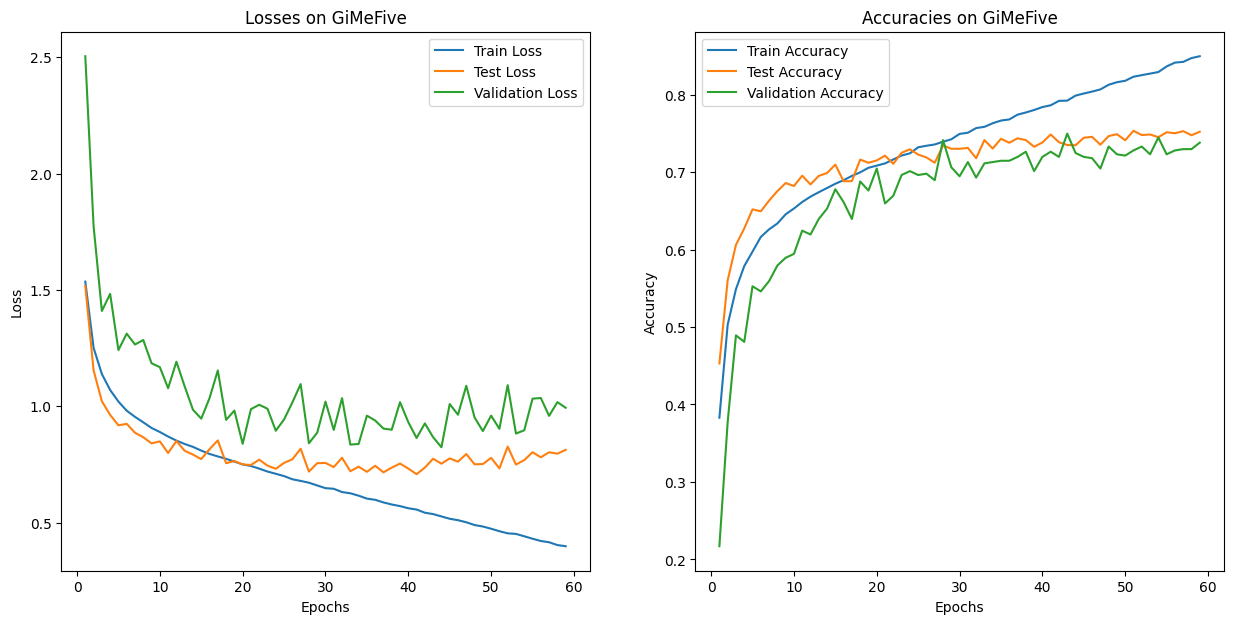

In [16]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, 60), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 60), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 60), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses on GiMeFive') # change
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 60), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 60), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 60), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies on GiMeFive') # change
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame({
    'Epoch': range(1, 60), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_gimefive.csv', index=False) # change this CSV